# Cutout data from fits files

## Imports

In [1]:
import sys
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

root = "/Users/phdenzel/gleam"
sys.path.append(root)
import gleam
from gleam.lensobject import LensObject
from gleam.multilens import MultiLens
from gleam.utils.plotting import IPColorbar, IPPointCache
from gleam.utils.plotting import plot_scalebar, plot_labelbox
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()

## Main

### Search for a fits file

In [2]:
directories = !ls -d lensedquasars/*/
pprint.pprint(list(enumerate(directories)))

[(0, 'lensedquasars/2M1134-2103/'),
 (1, 'lensedquasars/2M1310-1714/'),
 (2, 'lensedquasars/A2213-2652/'),
 (3, 'lensedquasars/APM08279+5255/'),
 (4, 'lensedquasars/B0128+437/'),
 (5, 'lensedquasars/B0218+357/'),
 (6, 'lensedquasars/B0445+123/'),
 (7, 'lensedquasars/B0631+519/'),
 (8, 'lensedquasars/B0712+472/'),
 (9, 'lensedquasars/B0739+366/'),
 (10, 'lensedquasars/B0850+054/'),
 (11, 'lensedquasars/B1030+074/'),
 (12, 'lensedquasars/B1127+385/'),
 (13, 'lensedquasars/B1152+199/'),
 (14, 'lensedquasars/B1359+154/'),
 (15, 'lensedquasars/B1422+231/'),
 (16, 'lensedquasars/B1555+375/'),
 (17, 'lensedquasars/B1600+434/'),
 (18, 'lensedquasars/B1608+656/'),
 (19, 'lensedquasars/B1933+503/'),
 (20, 'lensedquasars/B1938+666/'),
 (21, 'lensedquasars/B2045+265/'),
 (22, 'lensedquasars/B2108+213/'),
 (23, 'lensedquasars/B2114+022*/'),
 (24, 'lensedquasars/B2319+052/'),
 (25, 'lensedquasars/BRI0952-0115/'),
 (26, 'lensedquasars/COSMOS5921+0638/'),
 (27, 'lensedquasars/CY2201-3201/'),
 (28, 'le

In [4]:
files = !ls -d {directories[125]}*
# files = !ls lensedquasars/DESJ0408-5354_field.fits
files

['lensedquasars/RXJ1131-1231/RXJ1131-1231_PS_Y.fits',
 'lensedquasars/RXJ1131-1231/RXJ1131-1231_PS_g.fits',
 'lensedquasars/RXJ1131-1231/RXJ1131-1231_PS_i.fits',
 'lensedquasars/RXJ1131-1231/RXJ1131-1231_PS_r.fits',
 'lensedquasars/RXJ1131-1231/RXJ1131-1231_PS_z.fits',
 'lensedquasars/RXJ1131-1231/RXJ1131-1231_ic3u09010_FILTER_F218W_EXPTIME2268.0_drc.fits',
 'lensedquasars/RXJ1131-1231/RXJ1131-1231_ic3u09010_FILTER_F218W_EXPTIME2268.0_drc.fits.gz',
 'lensedquasars/RXJ1131-1231/RXJ1131-1231_ic3u09010_FILTER_F218W_EXPTIME2268.0_drz_cutout.fits',
 'lensedquasars/RXJ1131-1231/RXJ1131-1231_j9tx04010_FILTER_F165LP_NA_EXPTIME2520.0_drz_cutout.fits',
 'lensedquasars/RXJ1131-1231/RXJ1131-1231_j9ya08010_FILTER_F165LP_NA_EXPTIME2516.0_drz.fits',
 'lensedquasars/RXJ1131-1231/RXJ1131-1231_j9ya10010_FILTER_F165LP_NA_EXPTIME2516.0_drz.fits',
 'lensedquasars/RXJ1131-1231/hst_9744_74_acs_wfc_f814w_drz.fits',
 'lensedquasars/RXJ1131-1231/hst_9744_75_acs_wfc_f555w_drz.fits']

In [5]:
idx = -1
filename = os.path.basename(files[idx])
filepath = files[idx]
print(filepath)

lensedquasars/RXJ1131-1231/hst_9744_75_acs_wfc_f555w_drz.fits


### Read fits file and extract data

In [6]:
hdu = fits.open(filepath)
for h in hdu:
    if isinstance(h, fits.hdu.image.ImageHDU):
        hdu = h
        break
if isinstance(hdu, list):
    hdu = hdu[0]
print(hdu)
print(hdu.data.shape)
print(repr(hdu.header))

position = [p//2 for p in hdu.data.shape]

print(hdu.data.shape, position)
# print(repr(hhdu.header))

(5737, 5850)
XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5850                                                  
NAXIS2  =                 5737                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'        / Units of science product                       
                                                                                
CD1_1   = -1.38

In [7]:
lo = LensObject(filepath, auto=False, glscfactory_options={})
# lo.reorient(-lo.hdr['ORIENTAT'])
print(lo.__v__)

Properties of that field are unknown [None]
filename            	hst_9744_75_acs_wfc_f555w_drz.fits
filepath            	/Users/phdenzel/delays/data/lensedquasars/RXJ1131-1231/hst_9744_75_acs_wfc_f555w_drz.fits
band                	
naxis1              	5850
naxis2              	5737
naxis_plus          	None
refval              	[172.9495398825786, -12.52632616919377]
refpx               	[2925.499999999813, 2868.999999999817]
center              	<172.9495, -12.5263>
px2deg              	[1.3888888888888002e-05, 1.38888888888896e-05]
px2arcsec           	[0.049999999999996804, 0.050000000000002556]
megacam_range       	None
field               	None
photzp              	None
mag_formula         	<function mag_formula at 0x7f96cce32aa0>
roi                 	ROISelector(5737, 5850)
lens                	None
srcimgs             	[]
zl                  	0.5
zs                  	3.0
mapr                	146.25
tdelay              	None
tderr               	None
light_model         	{}
ste

### Plot the data

<IPython.core.display.Javascript object>


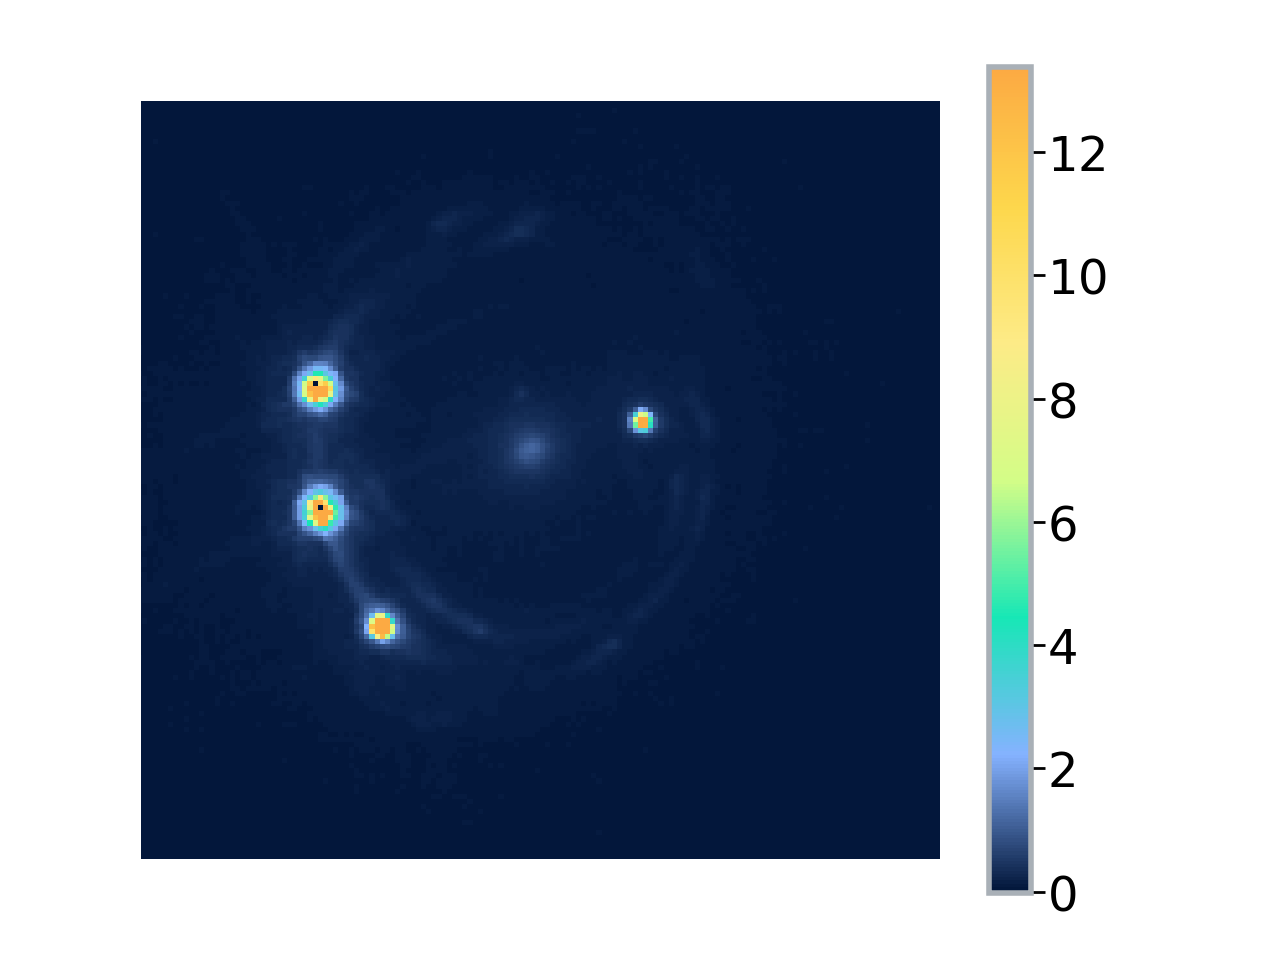

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2xvcm1hcCcsIGluZGV4PTE4OCwgbGF5b3V0PUxheW91dCh3aWR0aD11JzEwMCUnKSwgb3B0aW9ucz0odSdBY2NlbnQnLCDigKY=


Textarea(value=u'', description=u'Points', layout=Layout(height=u'200px', width=u'75%'), placeholder=u'Cache')

In [8]:
%matplotlib notebook

fig, ax = plt.subplots()
fig, ax, plt_out = lo.plot_f(fig, ax=ax, cmap=gcl.GLEAMcmaps.vilux, colorbar=True,
                             scalebar=False, origin='lower',
                             vmin=0, vmax=0.5*np.max(lo.data), source_images=False,
                             deconv=False, psf=np.ones((3, 3))/25.)
clrbar = IPColorbar(plt_out[1], plt_out[0])
clrbar.connect()
cache = IPPointCache(plt_out[0], use_modes=[])
cid = cache.connect()

In [9]:
%%script false
%matplotlib notebook

fig, ax = plt.subplots()
fig, ax, plt_out = lo.plot_f(fig, ax=ax, cmap=gcl.GLEAMcmaps.vilux, colorbar=False,
                             scalebar=False, extent=lo.extent,
                             vmin=0, vmax=2, source_images=False,
                             deconv=False, psf=np.ones((3, 3))/25.)
plot_scalebar(lo.extent[1], 50)
plot_labelbox(label='HST-ACS F814W', position='top left')
plt.axis('off')
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.savefig('HST_ACS_F814W_{}.pdf'.format(lensname), dpi=300, transparent=True)
plt.show()

In [10]:
if cache.xy:
    position = cache.xy[-1]
else:
    position = None
# plt.close()
print("Cutout center @ {}".format(position))

Cutout center @ [1893.1598115964352, 2381.271190274298]


In [11]:
fs = fig.axes[0].viewLim
delta = int(0.5 + max(abs(fs.x1-fs.x0), abs(fs.y1-fs.y0)))
delta = int(np.ceil(delta / 99.0)) * 99
size = (delta, delta) if delta < lo.data.shape[0] else lo.data.shape
if size == lo.data.shape:
    position = tuple(s//2 for s in lo.data.shape)
print("position: {}".format(position), "size: {}".format(size))

('position: [1893.1598115964352, 2381.271190274298]', 'size: (198, 198)')


### Ovewrite fits file and plot again

In [12]:
wcs = WCS(hdu.header)
cutout = Cutout2D(lo.data, position, size, wcs)
hdu.data = cutout.data
hdu.header.update(cutout.wcs.to_header())

<IPython.core.display.Javascript object>


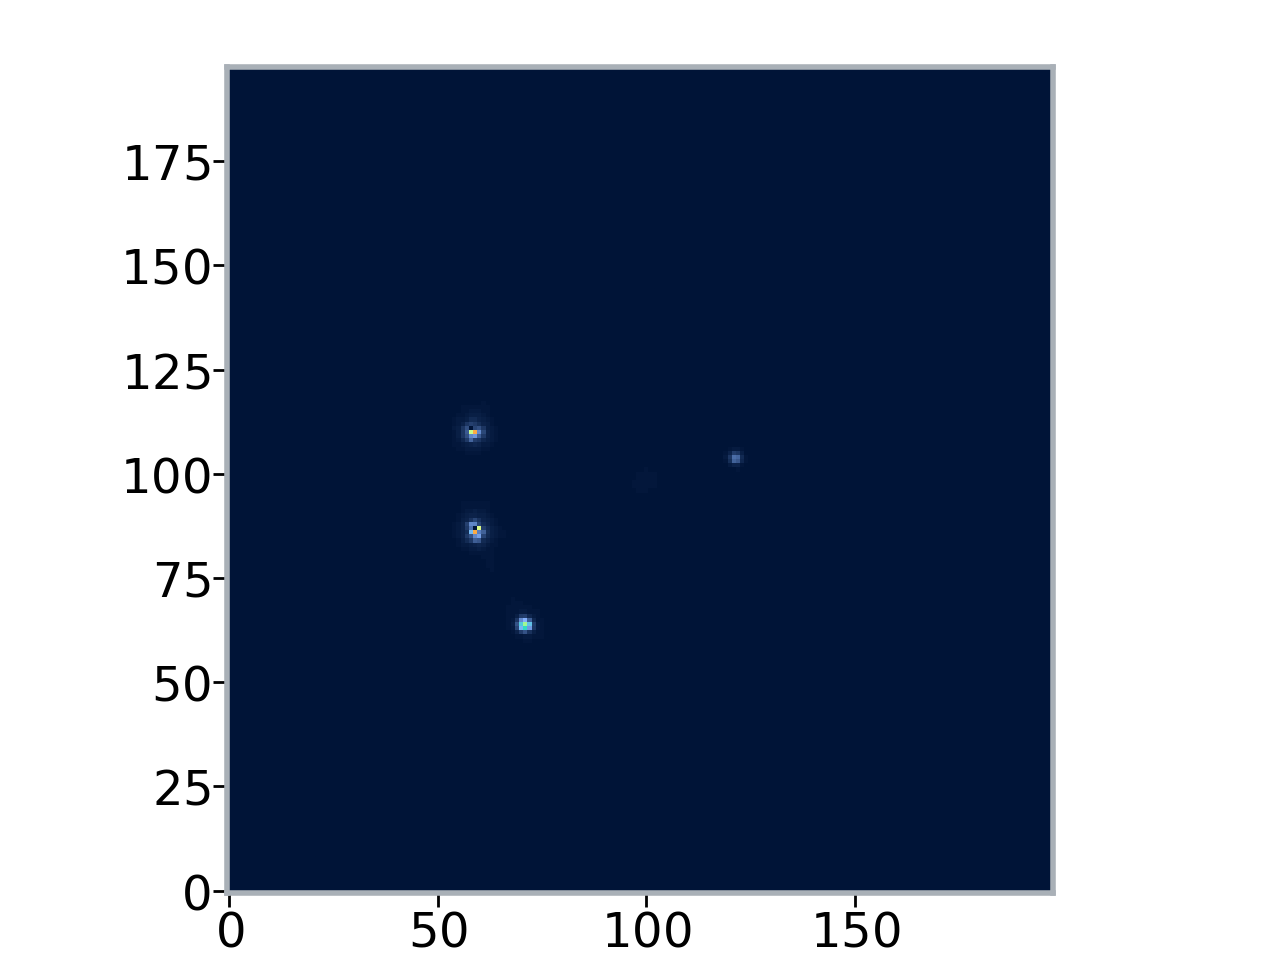

In [13]:
# show again for validation
%matplotlib notebook

kw = dict(cmap=gcl.GLEAMcmaps.vilux, vmin=np.nanmin(hdu.data)*0.9, vmax=np.nanmax(hdu.data)*0.9)

fig, ax = plt.subplots()
pltdta = hdu.data[:]
# pltdta = np.log10(pltdta+1+np.abs(np.nanmin(pltdta)))
ax.imshow(pltdta, origin='lower', **kw)

### Save file

In [14]:
savename = "{}.fits".format(os.path.dirname(filepath))
print("Saving {}...".format(savename))

Saving lensedquasars/RXJ1131-1231.fits...


In [15]:
hdu.writeto(savename, overwrite=True)